In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df=pd.read_csv(r'C:\Users\VISHAGAN\Downloads\black_friday_dataset.csv')
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [4]:
# unique values in each column
d1={}
for i in df.columns:
    d1[i] = df[i].nunique()
d1

{'User_ID': 5891,
 'Product_ID': 3631,
 'Gender': 2,
 'Age': 7,
 'Occupation': 21,
 'City_Category': 3,
 'Stay_In_Current_City_Years': 5,
 'Marital_Status': 2,
 'Product_Category_1': 20,
 'Product_Category_2': 17,
 'Product_Category_3': 15,
 'Purchase': 18105}

# Data cleaning and preprocessing

## Gender column

In [5]:
# performed label encoding
gender = {"F" : 0, "M" : 1}
df['gender'] = df['Gender'].map(gender)

## Age column

In [6]:
# performed label encoding
age={
               '0-17':1,
               '18-25':2,
               '26-35':3,
               '36-45':4,
               '46-50':5,
               '51-55':6,
               '55+':7
    }

In [7]:
df['age']=df['Age'].map(age)

## City_Category column

In [8]:
# performed label encoding
city = {
    "A" : 1,
    "B" : 2,
    "c" : 3
}

In [9]:
df['City_Category'] = df['City_Category'].map(city)

## Stay_In_Current_City_Years column

In [10]:
# perfromed label encoding and renaming of the column
dict_1 = {
            '0':0,
            '1':1,
            '2':2,
            '3':3,
            '4+':4
          }

df['city_residency_duration']=df['Stay_In_Current_City_Years'].map(dict_1)

df.drop(['Age','City_Category','Stay_In_Current_City_Years','Gender'],axis=1,inplace=True)

In [11]:
df.head()

,User_ID,Product_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,gender,age,city_residency_duration
0,1000001,P00069042,10,0,3,NaN,NaN,8370,0,1,2
1,1000001,P00248942,10,0,1,6.0,14.0,15200,0,1,2
2,1000001,P00087842,10,0,12,NaN,NaN,1422,0,1,2
3,1000001,P00085442,10,0,12,14.0,NaN,1057,0,1,2
4,1000002,P00285442,16,0,8,NaN,NaN,7969,1,7,4


## Splitting dataset

In [12]:
df.isna().sum()

User_ID                         0
Product_ID                      0
Occupation                      0
Marital_Status                  0
Product_Category_1              0
Product_Category_2         173638
Product_Category_3         383247
Purchase                        0
gender                          0
age                             0
city_residency_duration         0
dtype: int64

In [13]:
# column for number of categories a product_id belongs to
df['cat_count'] = 3 - (df.isna().sum(axis=1))
df_1 = df[df['cat_count'] == 1].drop(['Product_Category_2', 'Product_Category_3','cat_count'],axis=1)
df_2 = df[df['cat_count'] == 2].drop(['Product_Category_3','cat_count'],axis=1)
df_3 = df[df['cat_count'] == 3].drop(['cat_count'],axis=1)

## Feature Engineering

In [14]:
def pop_sco(df, col:list, agg_func:str, new_col_name:str, ascending = True):
    return df[col].groupby(col).Product_ID.agg(agg_func).to_frame(new_col_name).sort_values(by=new_col_name,ascending=ascending).reset_index()

In [15]:
prod_1 = pop_sco(df_1,['Product_ID'], 'count',"count_prod",False)
prod_2 = pop_sco(df_2,['Product_ID'], 'count',"count_prod",False)
prod_3 = pop_sco(df_3,['Product_ID'], 'count',"count_prod",False)

In [16]:
prod_1

,Product_ID,count_prod
0,P00255842,1383
1,P00278642,1226
2,P00031042,1200
3,P00258742,964
4,P00110542,958
...,...,...
1823,P00081642,1
1824,P00083142,1
1825,P00083542,1
1826,P00241842,1


In [17]:
scale_1 = MinMaxScaler()
scale_2 = MinMaxScaler()
scale_3 = MinMaxScaler()
prod_1["product_popularity_score"] = scale_1.fit_transform(prod_1[['count_prod']])
prod_2["product_popularity_score"] = scale_2.fit_transform(prod_2[['count_prod']])
prod_3["product_popularity_score"] = scale_3.fit_transform(prod_3[['count_prod']])

In [18]:
def score(col,x,y):
    return col.map(dict(zip(x,y)))

In [19]:
df_1['product_popularity_score'] = score(df_1['Product_ID'],prod_1.Product_ID,prod_1.product_popularity_score)
df_2['product_popularity_score'] = score(df_2['Product_ID'],prod_2.Product_ID,prod_2.product_popularity_score)
df_3['product_popularity_score'] = score(df_3['Product_ID'],prod_3.Product_ID,prod_3.product_popularity_score)

In [20]:
df_1.drop(['User_ID',	'Product_ID'],axis=1,inplace=True)
df_2.drop(['User_ID',	'Product_ID'],axis=1,inplace=True)
df_3.drop(['User_ID',	'Product_ID'],axis=1,inplace=True)

In [21]:
df_1.head()

,Occupation,Marital_Status,Product_Category_1,Purchase,gender,age,city_residency_duration,product_popularity_score
0,10,0,3,8370,0,1,2,0.163531
2,10,0,12,1422,0,1,2,0.073082
4,16,0,8,7969,1,7,4,0.146165
9,20,1,8,7871,1,3,1,0.573082
11,20,1,8,3957,1,3,1,0.485528


In [22]:
df_2.head()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Purchase,gender,age,city_residency_duration,product_popularity_score
3,10,0,12,14.0,1057,0,1,2,0.180947
5,15,0,1,2.0,15227,1,3,3,0.326770
7,7,1,1,15.0,15854,1,5,2,0.315061
8,7,1,1,16.0,15686,1,5,2,0.484832
10,20,1,5,11.0,5254,1,3,1,0.631187


In [23]:
df_3.head()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,gender,age,city_residency_duration,product_popularity_score
1,10,0,1,6.0,14.0,15200,0,1,2,0.359356
6,7,1,1,8.0,17.0,19215,1,5,2,0.891574
13,20,1,1,2.0,5.0,15665,1,3,1,0.870508
14,9,0,5,8.0,14.0,5378,0,6,1,0.050805
16,9,0,2,3.0,4.0,13055,0,6,1,0.107187


In [24]:
print("df_1 : {}\ndf_2: {}\ndf_3 : {}".format(df_1.shape,df_2.shape,df_3.shape))

df_1 : (173638, 8)
df_2: (209609, 9)
df_3 : (166821, 10)


# EDA

In [25]:
df_1.describe()

,Occupation,Marital_Status,Product_Category_1,Purchase,gender,age,city_residency_duration,product_popularity_score
count,173638.000000,173638.000000,173638.000000,173638.000000,173638.000000,173638.000000,173638.000000,173638.000000
mean,7.986322,0.416902,7.930908,7518.695389,0.744992,3.528438,1.852774,0.232204
std,6.560214,0.493048,4.037338,4142.460056,0.435867,1.366675,1.294650,0.201951
min,0.000000,0.000000,1.000000,12.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,5.000000,5254.000000,0.000000,3.000000,1.000000,0.080318
50%,7.000000,0.000000,8.000000,7075.000000,1.000000,3.000000,2.000000,0.168596
75%,14.000000,1.000000,8.000000,8783.000000,1.000000,4.000000,3.000000,0.325615
max,20.000000,1.000000,20.000000,23959.000000,1.000000,7.000000,4.000000,1.000000


In [26]:
df_2.describe()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Purchase,gender,age,city_residency_duration,product_popularity_score
count,209609.000000,209609.000000,209609.000000,209609.000000,209609.000000,209609.000000,209609.000000,209609.000000,209609.000000
mean,8.070259,0.409071,5.429433,12.186523,8804.312377,0.742683,3.502765,1.860488,0.226907
std,6.518223,0.491664,3.310195,4.236377,4913.735102,0.437157,1.356582,1.288806,0.184135
min,0.000000,0.000000,1.000000,2.000000,185.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,8.000000,5397.000000,0.000000,3.000000,1.000000,0.091006
50%,7.000000,0.000000,5.000000,14.000000,7878.000000,1.000000,3.000000,2.000000,0.180947
75%,14.000000,1.000000,8.000000,16.000000,11566.000000,1.000000,4.000000,3.000000,0.313997
max,20.000000,1.000000,15.000000,18.000000,23961.000000,1.000000,7.000000,4.000000,1.000000


In [27]:
df_3.describe()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,gender,age,city_residency_duration,product_popularity_score
count,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000,166821.000000
mean,8.178886,0.402839,2.742766,6.896871,12.668243,11658.114980,0.774645,3.455153,1.861690,0.379400
std,6.487522,0.490470,2.573969,4.500288,4.125338,5082.287959,0.417817,1.335119,1.284791,0.247405
min,0.000000,0.000000,1.000000,2.000000,3.000000,185.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,2.000000,9.000000,7869.000000,1.000000,3.000000,1.000000,0.192069
50%,7.000000,0.000000,1.000000,6.000000,14.000000,11756.000000,1.000000,3.000000,2.000000,0.328377
75%,14.000000,1.000000,4.000000,10.000000,16.000000,15626.000000,1.000000,4.000000,3.000000,0.509294
max,20.000000,1.000000,15.000000,16.000000,18.000000,23959.000000,1.000000,7.000000,4.000000,1.000000


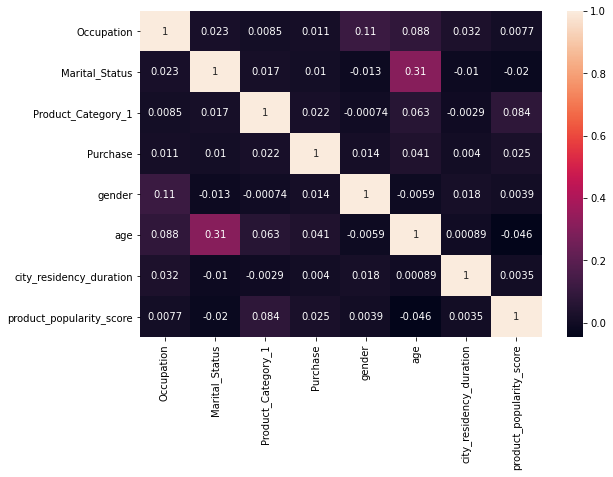

In [28]:
plt.figure(figsize=(9,6))
sns.heatmap(df_1.corr(),annot=True)
plt.show()

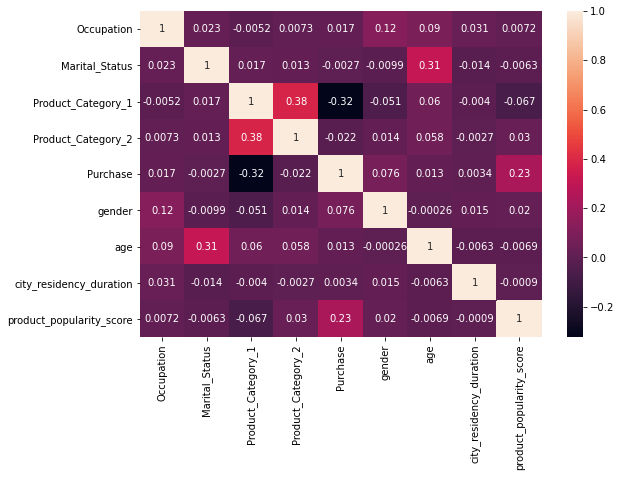

In [29]:
plt.figure(figsize=(9,6))
sns.heatmap(df_2.corr(),annot=True)
plt.show()

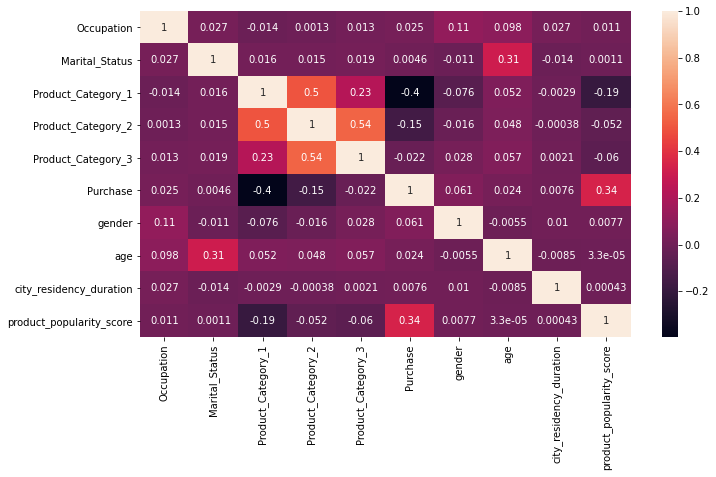

In [30]:
plt.figure(figsize=(11,6))
sns.heatmap(df_3.corr(),annot=True)
plt.show()

# Feature Scaling

In [31]:
scaler_1 = StandardScaler()
for i in df_1.drop(["Purchase"],axis=1).columns:
    df_1[i] = scaler_1.fit_transform(df_1[i].values.reshape(-1, 1))

In [32]:
scaler_2 = StandardScaler()
for i in df_2.drop(["Purchase"],axis=1).columns:
    df_2[i] = scaler_2.fit_transform(df_2[i].values.reshape(-1, 1))

In [33]:
scaler_3 = StandardScaler()
for i in df_3.drop(["Purchase"],axis=1).columns:
    df_3[i] = scaler_3.fit_transform(df_3[i].values.reshape(-1, 1))

In [34]:
df_3.head()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,gender,age,city_residency_duration,product_popularity_score
1,0.280711,-0.821334,-0.677075,-0.199293,0.322825,15200,-1.854033,-1.838907,0.107652,-0.081017
6,-0.181717,1.217531,-0.677075,0.245125,1.050040,19215,0.539365,1.157090,0.107652,2.070189
13,1.822136,1.217531,-0.677075,-1.088127,-1.858821,15665,0.539365,-0.340909,-0.670687,1.985042
14,0.126569,-0.821334,0.876949,0.245125,0.322825,5378,-1.854033,1.906089,-0.670687,-1.328165
16,0.126569,-0.821334,-0.288569,-0.865919,-2.101227,13055,-1.854033,1.906089,-0.670687,-1.100273


In [35]:
x1 = df_1.drop(["Purchase"],axis=1)
x2 = df_2.drop(["Purchase"],axis=1)
x3 = df_3.drop(["Purchase"],axis=1)
y1= df_1[["Purchase"]]
y2= df_2[["Purchase"]]
y3= df_3[["Purchase"]]

# Feature selection

In [36]:
imp_1 = ExtraTreesRegressor()
imp_1.fit(x1,y1)
for index,val in enumerate(imp_1.feature_importances_):
    print("{0} : {1} : {2}".format(x1.columns[index], index, round((val * 100),2)))

Occupation : 0 : 8.41
Marital_Status : 1 : 1.2
Product_Category_1 : 2 : 67.85
gender : 3 : 0.8
age : 4 : 2.98
city_residency_duration : 5 : 4.12
product_popularity_score : 6 : 14.65


In [37]:
x1.drop(['Marital_Status','gender'],axis=1,inplace=True)

In [38]:
imp_2 = ExtraTreesRegressor()
imp_2.fit(x2,y2)
for index,val in enumerate(imp_2.feature_importances_):
    print("{0} : {1} : {2}".format(x2.columns[index], index, round((val * 100),2)))

Occupation : 0 : 8.3
Marital_Status : 1 : 1.23
Product_Category_1 : 2 : 62.08
Product_Category_2 : 3 : 5.71
gender : 4 : 0.81
age : 5 : 3.84
city_residency_duration : 6 : 4.49
product_popularity_score : 7 : 13.55


In [39]:
x2.drop(['Marital_Status','gender'],axis=1,inplace=True)

In [40]:
imp_3 = ExtraTreesRegressor()
imp_3.fit(x3,y3)
for index,val in enumerate(imp_3.feature_importances_):
    print("{0} : {1} : {2}".format(x3.columns[index], index, round((val * 100),2)))

Occupation : 0 : 13.69
Marital_Status : 1 : 1.9
Product_Category_1 : 2 : 45.21
Product_Category_2 : 3 : 5.02
Product_Category_3 : 4 : 3.82
gender : 5 : 1.23
age : 6 : 5.89
city_residency_duration : 7 : 6.93
product_popularity_score : 8 : 16.31


In [41]:
x3.drop(['Marital_Status','gender'],axis=1,inplace=True)

# Spliting

In [42]:
x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size=0.2,random_state= 96)
x2_train,x2_test,y2_train,y2_test = train_test_split(x2,y2,test_size=0.2,random_state= 105)
x3_train,x3_test,y3_train,y3_test = train_test_split(x3,y3,test_size=0.2,random_state= 23)

# Model Evaluation and Selection

## Linear Regression

In [43]:
lr_1 = LinearRegression()
lr_2 = LinearRegression()
lr_3 = LinearRegression()

In [44]:
lr_1.fit(x1_train,y1_train)
lr_2.fit(x2_train,y2_train)
lr_3.fit(x3_train,y3_train)

LinearRegression()

In [45]:
y1_train_pred = lr_1.predict(x1_train)
y2_train_pred = lr_2.predict(x2_train)
y3_train_pred = lr_3.predict(x3_train)

In [46]:
y1_test_pred = lr_1.predict(x1_test)
y2_test_pred = lr_2.predict(x2_test)
y3_test_pred = lr_3.predict(x3_test)

In [47]:
def reg_eval(model : str, y_train, y_test, y_train_pred, y_test_pred):
    data =   {model:
              {"Train":
                  {
                      'MSE': mean_squared_error(y_train,y_train_pred) ,
                      'RMSE': np.square(mean_squared_error(y_train,y_train_pred)),
                      'R2_score': r2_score(y_train,y_train_pred),
                  },
               "Test":
                  {
                      'MSE': mean_squared_error(y_test,y_test_pred),
                      'RMSE': np.square(mean_squared_error(y_test,y_test_pred)),
                      'R2_score': r2_score(y_test,y_test_pred),

                  }
               }
            }
    return pd.DataFrame.from_dict({(i, j): data[i][j]
                              for i in data.keys()
                              for j in data[i].keys()},
                             orient='index')


In [48]:
reg_eval("Linear Regression_1", y1_train, y1_test, y1_train_pred, y1_test_pred)

MSE          RMSE  R2_score
Linear Regression_1 Train  1.707873e+07  2.916830e+14  0.003061
                    Test   1.724698e+07  2.974584e+14  0.001579

In [49]:
reg_eval("Linear Regression_2", y2_train, y2_test, y2_train_pred, y2_test_pred)

MSE          RMSE  R2_score
Linear Regression_2 Train  2.020810e+07  4.083675e+14  0.161897
                    Test   2.049891e+07  4.202052e+14  0.155601

In [50]:
reg_eval("Linear Regression_3", y3_train, y3_test, y3_train_pred, y3_test_pred)

MSE          RMSE  R2_score
Linear Regression_3 Train  1.970715e+07  3.883719e+14  0.237451
                    Test   1.967691e+07  3.871807e+14  0.236469

## Decision Tree

In [51]:
dctr_1 = DecisionTreeRegressor()
dctr_2 = DecisionTreeRegressor()
dctr_3 = DecisionTreeRegressor()

In [52]:
dctr_1.fit(x1_train,y1_train)
dctr_2.fit(x2_train,y2_train)
dctr_3.fit(x3_train,y3_train)

DecisionTreeRegressor()

In [53]:
dctr_1_y1_train_pred = dctr_1.predict(x1_train)
dctr_2_y2_train_pred = dctr_2.predict(x2_train)
dctr_3_y3_train_pred = dctr_3.predict(x3_train)

In [54]:
dctr_1_y1_test_pred = dctr_1.predict(x1_test)
dctr_2_y2_test_pred = dctr_2.predict(x2_test)
dctr_3_y3_test_pred = dctr_3.predict(x3_test)

In [55]:
reg_eval("Decision Tree Regression_1", y1_train, y1_test, dctr_1_y1_train_pred, dctr_1_y1_test_pred)

MSE          RMSE  R2_score
Decision Tree Regression_1 Train  1.688623e+06  2.851448e+12  0.901430
                           Test   8.135345e+06  6.618384e+13  0.529048

In [56]:
reg_eval("Decision Tree Regression_2", y2_train, y2_test, dctr_2_y2_train_pred, dctr_2_y2_test_pred)

MSE          RMSE  R2_score
Decision Tree Regression_2 Train  2.526571e+06  6.383560e+12  0.895214
                           Test   1.047811e+07  1.097908e+14  0.568382

In [57]:
reg_eval("Decision Tree Regression_3", y3_train, y3_test, dctr_3_y3_train_pred, dctr_3_y3_test_pred)

MSE          RMSE  R2_score
Decision Tree Regression_3 Train  5.013505e+06  2.513523e+13  0.806007
                           Test   1.639268e+07  2.687200e+14  0.363908

## RandomForest

In [58]:
rfr_1 = RandomForestRegressor()
rfr_2 = RandomForestRegressor()
rfr_3 = RandomForestRegressor()

In [59]:
rfr_1.fit(x1_train,y1_train)
rfr_2.fit(x2_train,y2_train)
rfr_3.fit(x3_train,y3_train)

RandomForestRegressor()

In [60]:
rfr_1_y1_train_pred = rfr_1.predict(x1_train)
rfr_2_y2_train_pred = rfr_2.predict(x2_train)
rfr_3_y3_train_pred = rfr_3.predict(x3_train)

In [61]:
rfr_1_y1_test_pred = rfr_1.predict(x1_test)
rfr_2_y2_test_pred = rfr_2.predict(x2_test)
rfr_3_y3_test_pred = rfr_3.predict(x3_test)

In [62]:
reg_eval("RandomForest Regression_1", y1_train, y1_test, rfr_1_y1_train_pred, rfr_1_y1_test_pred)

MSE          RMSE  R2_score
RandomForest Regression_1 Train  2.059372e+06  4.241015e+12  0.879788
                          Test   5.863885e+06  3.438515e+13  0.660542

In [63]:
reg_eval("RandomForest Regression_2", y2_train, y2_test, rfr_2_y2_train_pred, rfr_2_y2_test_pred)

MSE          RMSE  R2_score
RandomForest Regression_2 Train  2.969828e+06  8.819880e+12  0.876831
                          Test   7.847884e+06  6.158929e+13  0.676727

In [64]:
reg_eval("RandomForest Regression_3", y3_train, y3_test, rfr_3_y3_train_pred, rfr_3_y3_test_pred)

MSE          RMSE  R2_score
RandomForest Regression_3 Train  5.590047e+06  3.124863e+13  0.783699
                          Test   1.283541e+07  1.647476e+14  0.501943

## AdaBoost

In [65]:
abr_1 = AdaBoostRegressor()
abr_2 = AdaBoostRegressor()
abr_3 = AdaBoostRegressor()

In [66]:
abr_1.fit(x1_train,y1_train)
abr_2.fit(x2_train,y2_train)
abr_3.fit(x3_train,y3_train)

AdaBoostRegressor()

In [67]:
abr_1_y1_train_pred = abr_1.predict(x1_train)
abr_2_y2_train_pred = abr_2.predict(x2_train)
abr_3_y3_train_pred = abr_3.predict(x3_train)

In [68]:
abr_1_y1_test_pred = abr_1.predict(x1_test)
abr_2_y2_test_pred = abr_2.predict(x2_test)
abr_3_y3_test_pred = abr_3.predict(x3_test)

In [69]:
reg_eval("AdaBoost Regression_1", y1_train, y1_test, abr_1_y1_train_pred, abr_1_y1_test_pred)

MSE          RMSE  R2_score
AdaBoost Regression_1 Train  7.897642e+06  6.237276e+13  0.538990
                      Test   7.890867e+06  6.226579e+13  0.543201

In [70]:
reg_eval("AdaBoost Regression_2", y2_train, y2_test, abr_2_y2_train_pred, abr_2_y2_test_pred)

MSE          RMSE  R2_score
AdaBoost Regression_2 Train  1.117220e+07  1.248180e+14  0.536649
                      Test   1.122554e+07  1.260127e+14  0.537593

In [71]:
reg_eval("AdaBoost Regression_3", y3_train, y3_test, abr_3_y3_train_pred, abr_3_y3_test_pred)

MSE          RMSE  R2_score
AdaBoost Regression_3 Train  1.457375e+07  2.123941e+14  0.436083
                      Test   1.450735e+07  2.104632e+14  0.437065

## GradientBoost

In [72]:
gbr_1 = GradientBoostingRegressor()
gbr_2 = GradientBoostingRegressor()
gbr_3 = GradientBoostingRegressor()

In [73]:
gbr_1.fit(x1_train,y1_train)
gbr_2.fit(x2_train,y2_train)
gbr_3.fit(x3_train,y3_train)

GradientBoostingRegressor()

In [74]:
gbr_1_y1_train_pred = gbr_1.predict(x1_train)
gbr_2_y2_train_pred = gbr_2.predict(x2_train)
gbr_3_y3_train_pred = gbr_3.predict(x3_train)

In [75]:
gbr_1_y1_test_pred = gbr_1.predict(x1_test)
gbr_2_y2_test_pred = gbr_2.predict(x2_test)
gbr_3_y3_test_pred = gbr_3.predict(x3_test)

In [76]:
reg_eval("GradientBoostingRegressor_1", y1_train, y1_test, gbr_1_y1_train_pred, gbr_1_y1_test_pred)

MSE          RMSE  R2_score
GradientBoostingRegressor_1 Train  5.281385e+06  2.789302e+13  0.691709
                            Test   5.279257e+06  2.787056e+13  0.694386

In [77]:
reg_eval("GradientBoostingRegressor_2", y2_train, y2_test, gbr_2_y2_train_pred, gbr_2_y2_test_pred)

MSE          RMSE  R2_score
GradientBoostingRegressor_2 Train  7.022275e+06  4.931235e+13  0.708761
                            Test   7.094700e+06  5.033477e+13  0.707752

In [78]:
reg_eval("GradientBoostingRegressor_3", y3_train, y3_test, gbr_3_y3_train_pred, gbr_3_y3_test_pred)

MSE          RMSE  R2_score
GradientBoostingRegressor_3 Train  1.141840e+07  1.303799e+14  0.558176
                            Test   1.143767e+07  1.308203e+14  0.556179

## xgboost

In [79]:
xgbr_1 = XGBRegressor()
xgbr_2 = XGBRegressor()
xgbr_3 = XGBRegressor()

In [80]:
xgbr_1.fit(x1_train,y1_train)
xgbr_2.fit(x2_train,y2_train)
xgbr_3.fit(x3_train,y3_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [81]:
xgbr_1_y1_train_pred = xgbr_1.predict(x1_train)
xgbr_2_y2_train_pred = xgbr_2.predict(x2_train)
xgbr_3_y3_train_pred = xgbr_3.predict(x3_train)

In [82]:
xgbr_1_y1_test_pred = xgbr_1.predict(x1_test)
xgbr_2_y2_test_pred = xgbr_2.predict(x2_test)
xgbr_3_y3_test_pred = xgbr_3.predict(x3_test)

In [83]:
reg_eval("XGBoost Regression_1", y1_train, y1_test, xgbr_1_y1_train_pred, xgbr_1_y1_test_pred)

MSE          RMSE  R2_score
XGBoost Regression_1 Train  4.492482e+06  2.018240e+13   0.73776
                     Test   4.888439e+06  2.389684e+13   0.71701

In [84]:
reg_eval("XGBoost Regression_2", y2_train, y2_test, xgbr_2_y2_train_pred, xgbr_2_y2_test_pred)

MSE          RMSE  R2_score
XGBoost Regression_2 Train  6.004846e+06  3.605818e+13  0.750957
                     Test   6.418802e+06  4.120102e+13  0.735594

In [85]:
reg_eval("XGBoost Regression_3", y3_train, y3_test, xgbr_3_y3_train_pred, xgbr_3_y3_test_pred)

MSE          RMSE  R2_score
XGBoost Regression_3 Train  9.760469e+06  9.526676e+13  0.622328
                     Test   1.031013e+07  1.062987e+14  0.599932

# Hyper Parameter Tunning

In [86]:
from sklearn.model_selection import RandomizedSearchCV

In [87]:
def abr_params():
    params={
        'learning_rate': [1.0,0.01,0.1],
        'n_estimators': [250,500,750]
    }
    return params

def gbr_params():
    params={
        'n_estimators': [250,500,750],
        'max_features':['sqrt','log2','None'],
        'max_depth': [5,7,10]
    }
    return params


def random_cv(estimator,params):
    return RandomizedSearchCV(estimator=estimator,
                                       cv=10,n_iter=15,
                                       n_jobs=-1,random_state=93,
                                       param_distributions=params
                                      )

In [88]:
ls_1=[
    [AdaBoostRegressor(),random_cv(AdaBoostRegressor(),abr_params())],
    [GradientBoostingRegressor(),random_cv(GradientBoostingRegressor(),gbr_params())]
  ]

ls_2 = [
    [AdaBoostRegressor(),random_cv(AdaBoostRegressor(),abr_params())],
    [GradientBoostingRegressor(),random_cv(GradientBoostingRegressor(),gbr_params())]
    ]
ls_3 =[
     [AdaBoostRegressor(),random_cv(AdaBoostRegressor(),abr_params())],
     [GradientBoostingRegressor(),random_cv(GradientBoostingRegressor(),gbr_params())]
    ]

In [89]:
for model,param in ls_1:
    print("Model : ",str(model).split('(')[0] +"_"+'1')
    start=time.time()
    param.fit(x1_train,y1_train)
    print("\nBest Parameter : ", param.best_params_)
    end = time.time()
    print("\nTime taken : %.2f\n"%(end-start))
    model.set_params(**param.best_params_)
    model.fit(x1_train,y1_train)
    model_y1_train_pred = model.predict(x1_train)
    model_y1_test_pred = model.predict(x1_test)
    print(reg_eval(str(str(model).split('(')[0] +"_"+str(i)), y1_train, y1_test, model_y1_train_pred, model_y1_test_pred))

Model :  AdaBoostRegressor_1

Best Parameter :  {'n_estimators': 250, 'learning_rate': 1.0}

Time taken : 2461.20

                                                           MSE          RMSE  \
AdaBoostRegressor_product_popularity_score Train  7.915988e+06  6.266287e+13   
                                           Test   7.910884e+06  6.258209e+13   

                                                  R2_score  
AdaBoostRegressor_product_popularity_score Train  0.537919  
                                           Test   0.542042  
Model :  GradientBoostingRegressor_1

Best Parameter :  {'n_estimators': 750, 'max_features': 'sqrt', 'max_depth': 5}

Time taken : 5281.34

                                                                   MSE  \
GradientBoostingRegressor_product_popularity_score Train  4.544486e+06   
                                                   Test   4.853655e+06   

                                                                  RMSE  \
GradientBoostingRegress

In [90]:
for model,param in ls_2:
    print("Model : ",str(model).split('(')[0] +"_"+'2')
    start=time.time()
    param.fit(x2_train,y2_train)
    print("\nBest Parameter : ", param.best_params_)
    end = time.time()
    print("\nTime taken : %.2f\n"%(end-start))
    model.set_params(**param.best_params_)
    model.fit(x2_train,y2_train)
    model_y2_train_pred = model.predict(x2_train)
    model_y2_test_pred = model.predict(x2_test)
    print(reg_eval(str(str(model).split('(')[0] +"_"+str(i)), y2_train, y2_test, model_y2_train_pred, model_y2_test_pred))

Model :  AdaBoostRegressor_2

Best Parameter :  {'n_estimators': 250, 'learning_rate': 1.0}

Time taken : 4168.39

                                                           MSE          RMSE  \
AdaBoostRegressor_product_popularity_score Train  1.045915e+07  1.093937e+14   
                                           Test   1.052667e+07  1.108108e+14   

                                                  R2_score  
AdaBoostRegressor_product_popularity_score Train  0.566221  
                                           Test   0.566381  
Model :  GradientBoostingRegressor_2

Best Parameter :  {'n_estimators': 750, 'max_features': 'log2', 'max_depth': 7}

Time taken : 6695.56

                                                                   MSE  \
GradientBoostingRegressor_product_popularity_score Train  5.317722e+06   
                                                   Test   6.388009e+06   

                                                                  RMSE  \
GradientBoostingRegress

In [91]:
+for model,param in ls_3:
    print("Model : ",str(model).split('(')[0] +"_"+'3')
    start=time.time()
    param.fit(x3_train,y3_train)
    print("\nBest Parameter : ", param.best_params_)
    end = time.time()
    print("\nTime taken : %.2f\n"%(end-start))
    model.set_params(**param.best_params_)
    model.fit(x3_train,y3_train)
    model_y3_train_pred = model.predict(x3_train)
    model_y3_test_pred = model.predict(x3_test)
    print(reg_eval(str(str(model).split('(')[0] +"_"+str(i)), y3_train, y3_test, model_y3_train_pred, model_y3_test_pred))

Model :  AdaBoostRegressor_3

Best Parameter :  {'n_estimators': 750, 'learning_rate': 0.01}

Time taken : 3273.70

                                                           MSE          RMSE  \
AdaBoostRegressor_product_popularity_score Train  1.457026e+07  2.122925e+14   
                                           Test   1.453629e+07  2.113038e+14   

                                                  R2_score  
AdaBoostRegressor_product_popularity_score Train  0.436218  
                                           Test   0.435942  
Model :  GradientBoostingRegressor_3

Best Parameter :  {'n_estimators': 750, 'max_features': 'sqrt', 'max_depth': 5}

Time taken : 5037.10

                                                                   MSE  \
GradientBoostingRegressor_product_popularity_score Train  9.959904e+06   
                                                   Test   1.034747e+07   

                                                                  RMSE  \
GradientBoostingRegres